<a href="https://colab.research.google.com/github/LucinoGarcia/CodeFolio/blob/main/Smoking_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Import Packages and Data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [ ]:
SmokingSamples = pd.read_csv('/content/drive/MyDrive/Smoking Paper/All_SmokingSamples.csv', header=None).fillna(0)#[:20000]
NonSmokingSamples = pd.read_csv('/content/drive/MyDrive/Smoking Paper/All_NonSmokingSamples.csv', header=None).fillna(0)#[:20000]

WorkingInputs = pd.concat([SmokingSamples, NonSmokingSamples], ignore_index=True)
WorkingOutputs = pd.concat([pd.DataFrame(np.ones(len(SmokingSamples))), pd.DataFrame(np.zeros(len(NonSmokingSamples)))], ignore_index=True)

del SmokingSamples, NonSmokingSamples

# 1: Convolutional Neural Network

### 1.1 – Data Pre-Processing

In [ ]:
frames = []
x = WorkingInputs.loc[:, :99]
y = WorkingInputs.loc[:, 100:199]
z = WorkingInputs.loc[:, 200:]
frames.append([x, y, z])


WorkingInputs = np.asarray(frames).reshape(-1, 100, 3)
WorkingInputs.shape, WorkingOutputs.shape

((351530, 100, 3), (351530, 1))

In [ ]:
In_Train, In_Test, Out_Train, Out_Test =  train_test_split(WorkingInputs, WorkingOutputs, test_size = 0.2, random_state=321)
In_Train.shape, In_Test.shape

((281224, 100, 3), (70306, 100, 3))

In [ ]:
# CNN accepts 3 dimentional data so we are going to reshape() our data
In_Train = In_Train.reshape(In_Train.shape[0], 100, 3, 1)
In_Test = In_Test.reshape(In_Test.shape[0], 100, 3, 1)

### 1.2 – Building the CNN Model

In [ ]:
CNN = Sequential()
CNN.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = In_Train[0].shape))
CNN.add(Dropout(0.1))

CNN.add(Conv2D(32, (2, 2), activation='relu'))
CNN.add(Dropout(0.2))

CNN.add(Flatten())

CNN.add(Dense(64, activation = 'relu'))
CNN.add(Dropout(0.5))

CNN.add(Dense(1, activation='sigmoid'))


CNN.compile(optimizer=Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 2, 16)         80        
                                                                 
 dropout (Dropout)           (None, 99, 2, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 1, 32)         2080      
                                                                 
 dropout_1 (Dropout)         (None, 98, 1, 32)         0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                200768    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

### 1.3 – Training the CNN Model

In [ ]:
trainingEpochs = CNN.fit(In_Train, Out_Train, batch_size=200, epochs=6, validation_data= (In_Test, Out_Test), verbose=1)

Epoch 1/6
1407/1407 [==============================] - 155s 109ms/step - loss: 0.3066 - accuracy: 0.8580 - val_loss: 0.2171 - val_accuracy: 0.9077
Epoch 2/6
1407/1407 [==============================] - 156s 111ms/step - loss: 0.2177 - accuracy: 0.9058 - val_loss: 0.1829 - val_accuracy: 0.9175
Epoch 3/6
1407/1407 [==============================] - 150s 107ms/step - loss: 0.1966 - accuracy: 0.9147 - val_loss: 0.1841 - val_accuracy: 0.9207
Epoch 4/6
1407/1407 [==============================] - 170s 121ms/step - loss: 0.1856 - accuracy: 0.9207 - val_loss: 0.1661 - val_accuracy: 0.9287
Epoch 5/6
1407/1407 [==============================] - 155s 111ms/step - loss: 0.1787 - accuracy: 0.9243 - val_loss: 0.1600 - val_accuracy: 0.9295
Epoch 6/6
1407/1407 [==============================] - 158s 112ms/step - loss: 0.1731 - accuracy: 0.9264 - val_loss: 0.1643 - val_accuracy: 0.9254


### 1.4 – Loss v Epochs

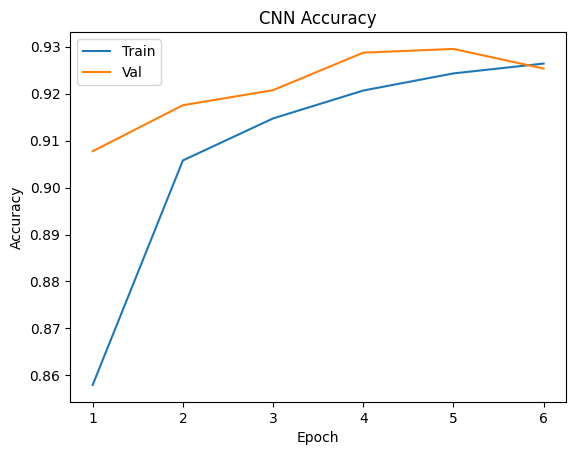

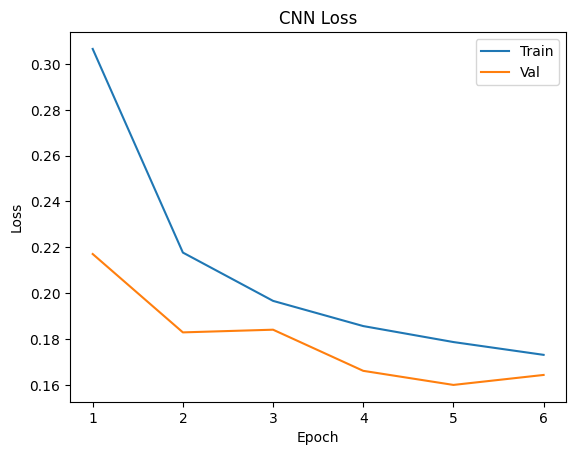

In [ ]:
epoch_range = range(1, 7)

plt.plot(epoch_range, trainingEpochs.history['accuracy'])
plt.plot(epoch_range, trainingEpochs.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(epoch_range, trainingEpochs.history['loss'])
plt.plot(epoch_range, trainingEpochs.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### 1.5 – Confusion Matrix and Model Evaluation

In [ ]:
pred_test = np.round(CNN.predict(In_Test))
cmCNN = confusion_matrix(Out_Test, pred_test)
print(cmCNN)

cmValues = {'tn': cmCNN[0, 0], 'fp': cmCNN[0, 1], 'fn': cmCNN[1, 0], 'tp': cmCNN[1, 1]}
print("Test Sensitivity: ", round(cmValues['tp'] / (cmValues['tp'] + cmValues['fn'])*100,2), "%")
print("Test Specificity: ", round(cmValues['tn'] / (cmValues['fp'] + cmValues['tn'])*100,2), "%")

2198/2198 [==============================] - 17s 8ms/step
[[31735  2959]
 [ 2289 33323]]
Test Sensitivity:  93.57 %
Test Specificity:  91.47 %


### 1.6 – Save CNN Model

In [ ]:
from tensorflow.keras.models import load_model
#CNN.save('/content/drive/MyDrive/Smoking Paper/Saved Models/CNN.hdf5')